# LOADING DATASET


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 12 11:32:10 2022

@author: YAHYAOUI_Aya
"""

import pandas as pd
import numpy as np
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import glob
from xml.etree import ElementTree


annotations_directory = '../ProjetDetectionMask/dataset/annotations'
images_directory = '../ProjetDetectionMask/dataset/images'

information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('\\')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]
                            
                            
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height
0,79,105,109,142,without_mask,maksssksksss0,512,366
1,185,100,226,144,with_mask,maksssksksss0,512,366
2,325,90,360,141,without_mask,maksssksksss0,512,366
3,321,34,354,69,with_mask,maksssksksss1,400,156
4,224,38,261,73,with_mask,maksssksksss1,400,156
5,299,58,315,81,with_mask,maksssksksss1,400,156
6,143,74,174,115,with_mask,maksssksksss1,400,156
7,74,69,95,99,with_mask,maksssksksss1,400,156
8,191,67,221,93,with_mask,maksssksksss1,400,156
9,21,73,44,93,with_mask,maksssksksss1,400,156


In [4]:
# Add Annotation and Image File Names
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'

# Tidy Grammatical Issue
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png
...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png
4069,181,54,273,162,mask_incorrectly_worn,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png


In [5]:
def render_image(image_path):
    image = cv2.imread(image_path)
    img=image_path.split('\\')[-1]
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
        (x,y,width,height)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                        annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
        bound_box.append((x,y,width,height))  
        if annotations_info_df.loc[i].label=='with_mask':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 200, 0), 2)
            cv2.putText(image, org = (x-8 , y-8), text = "Mask", 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (0, 200, 0))
        elif annotations_info_df.loc[i].label=='mask_incorrectly_worn':
            cv2.rectangle(image, (x,y), (x+width, y+height), (255, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Incorrect', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        else:
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'No mask', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (200, 0, 0))
        
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    
    return bound_box,image

In [6]:
images_with_2=[]
for _ in annotations_info_df['image_file'].value_counts().index:
    if annotations_info_df[annotations_info_df['image_file']==_].shape[0]==2:
        images_with_2.append(_)


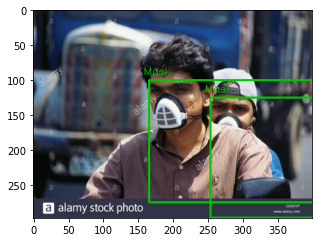

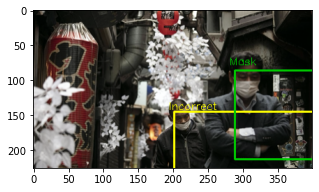

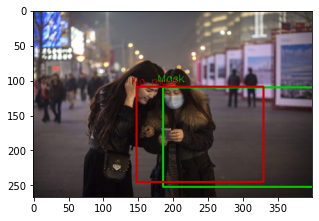

In [7]:
for i in images_with_2[:3]:
    
    render_image(os.path.join(images_directory,i))

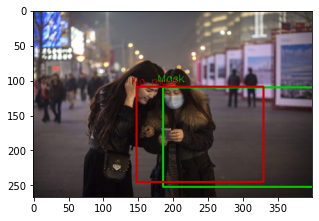

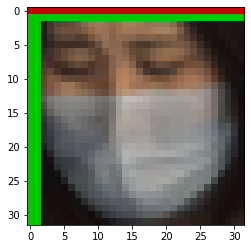

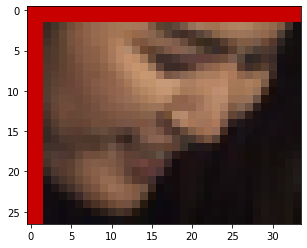

In [8]:
bound_box,image=render_image(os.path.join(images_directory,i))
for i in bound_box:
    cropped = image[i[1]:i[3],i[0]:i[2]]
    plt.imshow(cropped)
    plt.show()
    

#   EXTRACT FACES

In [ ]:

directory = 'cropped_images'
parent_directory = '../ProjetDetectionMask/dataset/'
path = os.path.join(parent_directory, directory)
os.mkdir(path)

In [9]:

annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file,cropped_image_file
0,79,105,109,142,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
1,185,100,226,144,with_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
2,325,90,360,141,without_mask,maksssksksss0,512,366,maksssksksss0.xml,maksssksksss0.png,maksssksksss0
3,321,34,354,69,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
4,224,38,261,73,with_mask,maksssksksss1,400,156,maksssksksss1.xml,maksssksksss1.png,maksssksksss1
...,...,...,...,...,...,...,...,...,...,...,...
4067,263,62,287,85,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4068,344,80,377,106,with_mask,maksssksksss98,400,267,maksssksksss98.xml,maksssksksss98.png,maksssksksss98
4069,181,54,273,162,mask_incorrectly_worn,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99
4070,99,87,176,165,with_mask,maksssksksss99,400,267,maksssksksss99.xml,maksssksksss99.png,maksssksksss99


In [10]:

for i in range(len(annotations_info_df)):
    
    # Get The File Path and Read The Image
    image_filepath = '../ProjetDetectionMask/dataset/images/' + annotations_info_df['image_file'].iloc[i]
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[i]

    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('../ProjetDetectionMask/dataset/cropped_images', cropped_image_filename)
    
    cropped_image_directory = cropped_image_directory.replace("\\","/")
    cv2.imwrite(cropped_image_directory, cropped_image)

C:\Users\YAHYAOUIAya\anaconda3_1\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# DATA PREPROCESSING

In [11]:
classes=annotations_info_df['label'].unique()
labels=annotations_info_df['label']
annotations_info_df.drop(['label'],axis=1,inplace=True)
print(labels)

0                without_mask
1                   with_mask
2                without_mask
3                   with_mask
4                   with_mask
                ...          
4067                with_mask
4068                with_mask
4069    mask_incorrectly_worn
4070                with_mask
4071                with_mask
Name: label, Length: 4072, dtype: object


In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)
print(X_train.shape,X_test.shape)
X_train['label']=Y_train
X_test['label']=Y_test

(3054, 10) (1018, 10)


C:\Users\YAHYAOUIAya\anaconda3_1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\YAHYAOUIAya\anaconda3_1\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
image_width = []
image_height = []
for i in range(len(X_train)):
    cropped_image_path = '../ProjetDetectionMask/dataset/cropped_images/' + X_train['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [14]:
from keras_preprocessing.image import ImageDataGenerator
image_target_size = (int(60), int(60))

train_image_generator = ImageDataGenerator(rescale = 1. / 255.)
train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = '../ProjetDetectionMask/dataset/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

class_ind=train_generator.class_indices

test_image_generator = ImageDataGenerator(rescale = 1. / 255.)
test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = '../ProjetDetectionMask/dataset/cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

Found 3054 validated image filenames belonging to 3 classes.
Found 1018 validated image filenames belonging to 3 classes.


# Creating / Training MODEL

In [15]:
def mask_model(nb_class):
    mask_model = tf.keras.Sequential()
    mask_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(60,60, 3)))
    mask_model.add(tf.keras.layers.BatchNormalization())
    mask_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    mask_model.add(tf.keras.layers.BatchNormalization())
    mask_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
    mask_model.add(tf.keras.layers.BatchNormalization())
    mask_model.add(tf.keras.layers.Flatten()) 
    mask_model.add(tf.keras.layers.Dense(256, activation='relu'))
    mask_model.add(tf.keras.layers.Dropout(0.5))
    mask_model.add(tf.keras.layers.Dense(64, activation='relu'))
    mask_model.add(tf.keras.layers.Dense(nb_class, activation='softmax'))

    mask_model.compile(loss = 'categorical_crossentropy',optimizer = keras.optimizers.Adam(lr=0.001),metrics = ['accuracy'])
    print(mask_model.summary())
    return mask_model

mask_model = mask_model(len(class_ind))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 58, 58, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 54, 54, 128)       512       
_________________________________________________________________
flatten (Flatten)            (None, 373248)            0

[INFO] Training model ..
Epoch 1/10
96/96 [==============================] - 222s 2s/step - loss: 18.1835 - accuracy: 0.8644 - val_loss: 7.0732 - val_accuracy: 0.7957
Epoch 2/10
96/96 [==============================] - 217s 2s/step - loss: 11.7246 - accuracy: 0.8847 - val_loss: 14.6689 - val_accuracy: 0.5747
Epoch 3/10
96/96 [==============================] - 220s 2s/step - loss: 6.9110 - accuracy: 0.9005 - val_loss: 4.0593 - val_accuracy: 0.7760
Epoch 4/10
96/96 [==============================] - 272s 3s/step - loss: 4.6538 - accuracy: 0.8982 - val_loss: 3.8486 - val_accuracy: 0.8811
Epoch 5/10
96/96 [==============================] - 192s 2s/step - loss: 4.8087 - accuracy: 0.9034 - val_loss: 2.9091 - val_accuracy: 0.7672
Epoch 6/10
96/96 [==============================] - 196s 2s/step - loss: 4.6661 - accuracy: 0.8995 - val_loss: 2.3670 - val_accuracy: 0.9175
Epoch 7/10
96/96 [==============================] - 204s 2s/step - loss: 2.1782 - accuracy: 0.9211 - val_loss: 2.1695 - val_ac

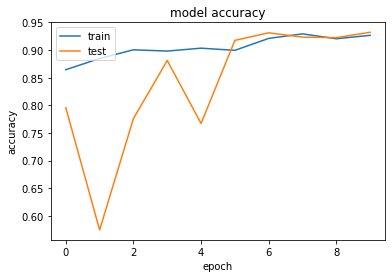

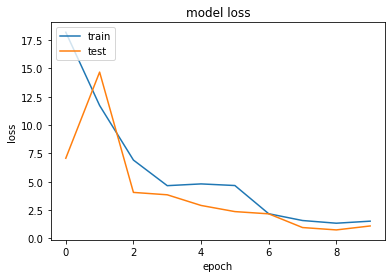

In [16]:
def Training_model(train_generator, test_generator, mask_model):
    
      # Train the neural network/model doe 60 epochs
    history = mask_model.fit(x=train_generator,validation_data=test_generator,epochs=10)
      
      # Plotting loss and accuracy of validation set and training set 
    print(history.history.keys())
    plt.figure(1)
      
      # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
      
      # summarize history for loss
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
      

    return mask_model
print("[INFO] Training model ..")
mask_model = Training_model(train_generator, test_generator, mask_model)

In [17]:
# save trained model in .h5 file for predictions
mask_model.save('../ProjetDetectionMask/trained_model/mask_model.h5')

# FACE DETECTION IN REAL TIME AND MASK POSITION PREDICTION

In [20]:
import cv2
import os
import numpy as np
import tensorflow as tf


def Face_Mask_detector():
    
    # Importing the OpenCv cascade classifier for faces 
    cascPath=os.path.dirname(cv2.__file__)+"/data/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    # Importing the trained model
    trained_model =  tf.keras.models.load_model('../ProjetDetectionMask/trained_model/mask_model.h5')
    
    # Opening Webcam
    video_capture = cv2.VideoCapture(0)
    
    mask_dict = {0: "mask_incorrectly_worn", 1: "with_mask", 2: "without_mask"}
    
    while True:
         # Capture frame-by-frame
         ret, frame = video_capture.read()
         
         if not ret:
             break
    
         # Turning images from BRG to Gray 
         gray = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
         # face detection
         faces = faceCascade.detectMultiScale(
              gray,
              scaleFactor=1.1,
              minNeighbors=5,
              minSize=(60, 60),
              flags=cv2.CASCADE_SCALE_IMAGE
          )
         # Draw a rectangle around the faces
         if ret == True:     
              for x1,y1,h,w in faces:
                  
                  x2, y2 = x1 + w, y1 + h
                  face = frame[y1:y2, x1:x2]
                  gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    
                  cv2.rectangle(frame,  (x1, y1), (x2, y2), (0, 255, 255), 2)
                  
                  # Preparing the detected face for prediction (input shape)
                  img = cv2.resize(gray_face, (60,60))
                  img = img /255
                  img = np.array(img)
                  img = np.expand_dims(img, axis=0)
                  img = img.reshape(1,60,60,3)
                
                  # Make prediction on the detected face
                  prediction = trained_model.predict(img)  
                  print(prediction)
                  maxindex = int(np.argmax(prediction))
                  
                  # write the prediction above the face
                  cv2.putText(frame, mask_dict[maxindex],(x1+20, y1-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                         
         # Display the resulting frame
         cv2.imshow('Video', frame)
         if cv2.waitKey(1) & 0xFF == ord('q'):
             break
    
    # When everything is done, release the capture
    video_capture.release()
    cv2.destroyAllWindows()


Face_Mask_detector()

[[5.4759528e-07 2.0074435e-04 9.9979872e-01]]
[[6.5001711e-07 2.1656744e-04 9.9978274e-01]]
[[4.3262136e-07 1.7572775e-04 9.9982387e-01]]
[[7.7385556e-07 2.6072137e-04 9.9973851e-01]]
[[8.4762996e-07 2.6434421e-04 9.9973482e-01]]
[[3.6671586e-06 6.7906338e-04 9.9931729e-01]]
[[3.7881807e-06 6.8663427e-04 9.9930954e-01]]
[[4.1435123e-06 7.2429591e-04 9.9927157e-01]]
[[2.1029468e-06 4.8867060e-04 9.9950922e-01]]
[[4.6643704e-06 7.7528687e-04 9.9922001e-01]]
[[6.5882396e-06 9.6855260e-04 9.9902487e-01]]
[[4.9812234e-06 8.0614875e-04 9.9918884e-01]]
[[1.7474531e-06 3.9425836e-04 9.9960405e-01]]
[[1.7018712e-06 4.1906832e-04 9.9957925e-01]]
[[2.2079437e-06 4.9457030e-04 9.9950325e-01]]
[[1.1715865e-06 3.2067584e-04 9.9967813e-01]]
[[5.1694508e-07 1.9101569e-04 9.9980849e-01]]
[[2.3017749e-06 5.1586801e-04 9.9948186e-01]]
[[4.2476057e-07 1.6994021e-04 9.9982965e-01]]
[[5.9722396e-07 1.9502845e-04 9.9980444e-01]]
[[3.1091065e-07 9.0589601e-05 9.9990904e-01]]
[[7.4428095e-07 1.7546416e-04 9.99